# Imports

In [1]:
from google.oauth2 import service_account
from google.cloud import monitoring_v3
import time
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import itertools
import datetime
import matplotlib.dates as mdates

# Data Import

In [17]:
credentials = service_account.Credentials.from_service_account_file(
    '../infrastructure/credentials.json')

project_id = '932771810925' # Our project ID

client = monitoring_v3.MetricServiceClient(credentials=credentials)
project_name = f"projects/{project_id}"
now = time.time()
seconds = int(now)
nanos = int((now - seconds) * 10 ** 9)
interval = monitoring_v3.TimeInterval(
    {
        "end_time": {"seconds": seconds, "nanos": nanos},
        # 3600 = Get the last hour of metrics
        "start_time": {"seconds": (seconds - (3600 * 5)), "nanos": nanos},
    }
)

In [18]:
results_cpu = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type =  "compute.googleapis.com/instance/cpu/utilization"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_io_read = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/read_bytes_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_io_write = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/write_bytes_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_iops_read = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/read_ops_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)
results_iops_write = client.list_time_series(
    request={
        "name": project_name,
        "filter": 'metric.type = "compute.googleapis.com/instance/disk/write_ops_count"',
        "interval": interval,
        "view": monitoring_v3.ListTimeSeriesRequest.TimeSeriesView.FULL,
    }
)

df = pd.DataFrame()
set_timestamp_column = True
first_len = 0
for ts_cpu, ts_io_read, ts_io_write, ts_iops_read, ts_iops_write in zip(results_cpu, results_io_read, results_io_write, results_iops_read, results_iops_write):
    # print(ts)
    label = ts_cpu.metric.labels["instance_name"]
    print(label + ": " + str(len(ts_cpu.points)))
    if set_timestamp_column:
        df['timestamp'] = pd.to_datetime([p.interval.start_time for p in ts_cpu.points])
        first_len=len(ts_cpu.points)
        set_timestamp_column = False
    # print(ts.points[0])
    # When deploying the vm they might take different amount of time leading to some values beeing available a minute early this leading to different length
    # We can trim off the last values as they are orderer from most recent to last
    df['cpu_util_' + label] = [p.value.double_value for p in ts_cpu.points[:first_len]]
    df['io_read_' + label] = [p.value.int64_value for p in ts_io_read.points[:first_len]]
    df['io_write_' + label] = [p.value.int64_value for p in ts_io_write.points[:first_len]]
    df['iops_read_' + label] = [p.value.int64_value for p in ts_iops_read.points[:first_len]]
    df['iops_write_' + label] = [p.value.int64_value for p in ts_iops_write.points[:first_len]]

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)
columns = df.columns
df.to_csv("export.csv")
df.head()



syncmesh-instance-2: 297
syncmesh-instance-3: 297
syncmesh-instance-1: 297
test-orchestrator: 297
client-instance: 297
central-server-instance: 297


,cpu_util_syncmesh-instance-2,io_read_syncmesh-instance-2,io_write_syncmesh-instance-2,iops_read_syncmesh-instance-2,iops_write_syncmesh-instance-2,cpu_util_syncmesh-instance-3,io_read_syncmesh-instance-3,io_write_syncmesh-instance-3,iops_read_syncmesh-instance-3,iops_write_syncmesh-instance-3,...,cpu_util_client-instance,io_read_client-instance,io_write_client-instance,iops_read_client-instance,iops_write_client-instance,cpu_util_central-server-instance,io_read_central-server-instance,io_write_central-server-instance,iops_read_central-server-instance,iops_write_central-server-instance
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-07-20 00:43:00+00:00,0.103435,62615,1072870,14,146,0.755203,947256698,205664,16272,42,...,0.008176,0,238075,0,49,0.038123,0,479825,0,40
2021-07-20 00:42:00+00:00,0.100178,280898,1082206,14,148,0.858510,941316444,220246,16199,45,...,0.005285,0,112067,0,23,0.039150,0,528126,0,46
2021-07-20 00:41:00+00:00,0.100878,242955,903581,12,111,1.046742,946901671,248127,16303,48,...,0.005623,0,0,0,0,0.038884,0,484924,0,41
2021-07-20 00:40:00+00:00,0.100011,194863,966834,8,127,1.102235,937440618,353316,16472,64,...,0.006078,0,194241,2,39,0.039035,0,544514,0,49
2021-07-20 00:39:00+00:00,0.099778,116571,908262,30,114,0.781592,933300676,261458,16582,49,...,0.007651,203832,161515,2,28,0.039302,0,539198,0,47


# Test

## CPU

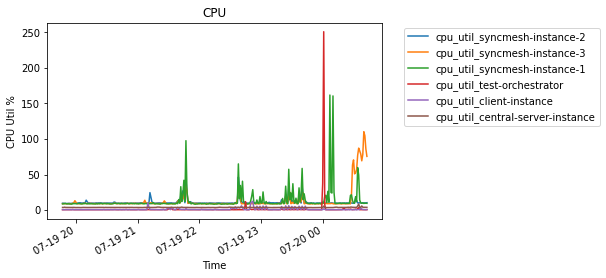

In [19]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("cpu_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('CPU')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IO

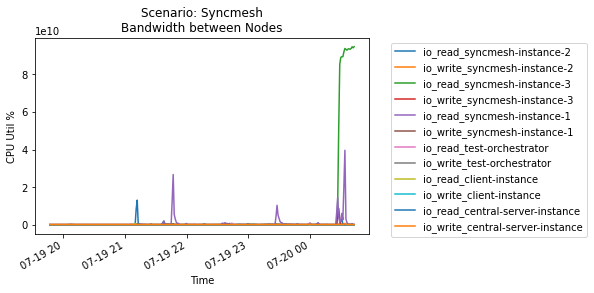

In [20]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("io_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()

## IOPS

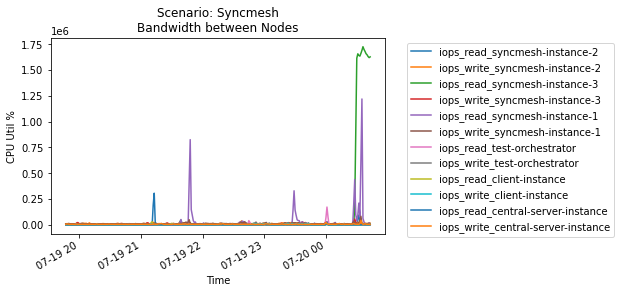

In [21]:
df = pd.read_csv("export.csv")
df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)

fig, ax = plt.subplots()

# ax.set_ylim(0,500)
for col in columns: 
    if col.startswith("iops_"):
        ax.plot(df.index, df[col]*100, label=col)
# set title and legend
ax.set_title('Scenario: Syncmesh\nBandwidth between Nodes')
ax.set_ylabel("CPU Util %")
ax.set_xlabel("Time")
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
box = ax.get_position()
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
fig.autofmt_xdate()

fig.savefig("out/cpu_util.png")
plt.show()